In [90]:
#part 5 feature selection
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pandas as pd
import matplotlib.pyplot as plt 
from pandas.tools.plotting import scatter_matrix
from scipy import stats 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import featuretools as ft
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor
from sklearn import preprocessing
from itertools import combinations
from sklearn.base import clone
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from featuretools import variable_types as vtypes
import math

In [275]:
df = pd.read_csv('/Users/chenlianxu/Desktop/cleaned_data.csv')
X = df.iloc[:,3:40]
y = df['Appliances']
X.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,NSM,Dayoftheweek_Friday,Dayoftheweek_Monday,Dayoftheweek_Saturday,Dayoftheweek_Sunday,Dayoftheweek_Thursday,Dayoftheweek_Tuesday,Dayoftheweek_Wednesday,Weekdaystatus_Weekday,Weekdaystatus_Weekend
0,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,61200.0,0,1,0,0,0,0,0,1,0
1,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,61800.0,0,1,0,0,0,0,0,1,0
2,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,62400.0,0,1,0,0,0,0,0,1,0
3,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,63000.0,0,1,0,0,0,0,0,1,0
4,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,63600.0,0,1,0,0,0,0,0,1,0


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, random_state=0 )

# Random forest  feature importances

In [136]:
#for compute convience , we use 100 estimator
rf = RandomForestRegressor(n_estimators = 100 , random_state = 42, max_features=18)
rf.fit(X_train, y_train)
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [168]:
ft_tree = pd.DataFrame(feature_importances)
ft_tree.columns = ['feature','importance']
ft_tree.set_index(['feature'])
ft_tree.iloc[0,:]['importance']

0.15

In [169]:
ft_tree['importance'] = ft_tree.importance/ft_tree.iloc[0,:]['importance']

Text(0.5,0,'RF Variable Importance')

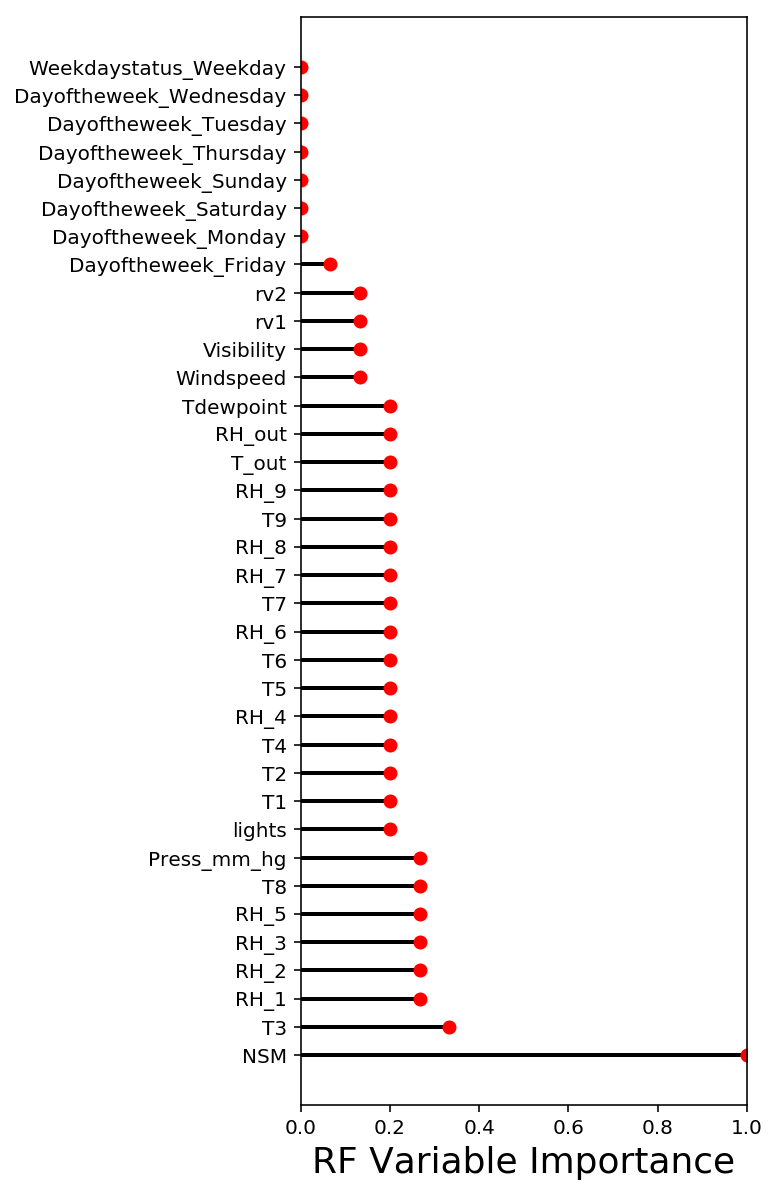

In [192]:
plt.figure(figsize=(4,10))
plt.xlim(0,1)
for key,value in zip(range(1,37),ft_tree['importance']):
    plt.axhline(y=key, xmin=0, xmax=value, linewidth=2, color = 'k')
    #plt.scatter([value, ], [key, ], s=0.5, color='b')
    plt.plot([value],[key], 'ro')
plt.yticks(range(1,37),ft_tree['feature'])
#plt.get_xaxis().set_ticks([0,20,40,60,80,100])
#plt.xticks([0,20,40,60,80,100])
plt.xlabel("RF Variable Importance",fontsize=18)


# use exhaustive search 

In [195]:
class EX():
    def __init__(self, estimator,k_features,
               test_size=0.25,random_state=1):
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    def fit(self,X,y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                                                           random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train,y_train,
                                X_test,y_test,self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train,y_train,
                                X_test,y_test,p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -=1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self,X):
        return X[:,self.indices_]
    def _calc_score(self, X_train,y_train,
                   X_test,y_test,indices):
        self.estimator.fit(X_train[:,indices],y_train)
        y_pred = self.estimator.predict(X_test[:,indices])
        score = r2_score(y_test,y_pred)
        return score
            

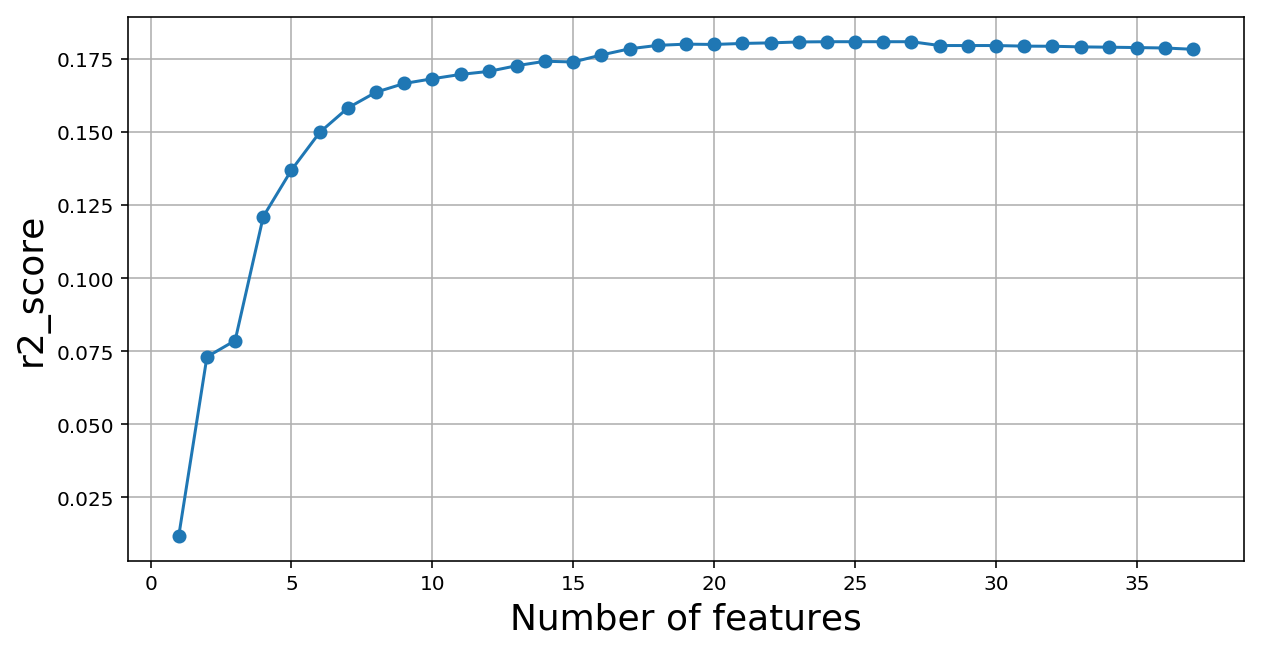

In [197]:
#linear model exhaustive search
linear_ex = LinearRegression()
ex = EX(linear_ex,k_features=1)
ex.fit(X_train.values, y_train.values)


k_feat = [len(k) for k in ex.subsets_]
plt.figure(figsize=(10,5))
plt.plot(k_feat, ex.scores_,marker='o')
plt.ylabel('r2_score', fontsize=18)
plt.xlabel('Number of features',fontsize= 18)
plt.grid()
plt.show()

In [36]:
k10 = list(ex.subsets_[16])
print(X.columns[k10])

Index(['lights', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T6', 'T8', 'RH_8', 'T9'], dtype='object')


# use forward search

In [240]:
#linear_model with forward search
linear_forward = LinearRegression()
sfs = SFS(linear_forward, k_features=37, forward=True,scoring='r2' )
sfs.fit(X_train.values, y_train.values)

Index(['lights', 'RH_1', 'RH_2', 'RH_7', 'RH_8', 'RH_out', 'NSM',
       'Dayoftheweek_Thursday', 'Dayoftheweek_Tuesday',
       'Dayoftheweek_Wednesday'],
      dtype='object')


In [251]:
list_sfs = []
for key,value in sfs.subsets_.items():
    feature = value['feature_idx']
    main_list = np.setdiff1d(feature,list_sfs)
    for x in main_list:
        list_sfs.append(x)
       


In [256]:
list_sfs_ = list(X.columns[list_sfs])

# use backward search

In [ ]:
rf_for_sbs = RandomForestRegressor(n_estimators = 100)
sbs_rf = SFS(rf_for_sbs, k_features=36, forward=False,scoring='r2',cv = 5,step = 3 )
sbs_rf.fit(X_train.values, y_train.values)

In [264]:
#linear_model with backward search
linear_backward = LinearRegression()
sbs = SFS(linear_backward, k_features=1, forward=False,scoring='r2' )
sbs.fit(X_train.values, y_train.values)


SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
             floating=False, forward=False, k_features=1, n_jobs=1,
             pre_dispatch='2*n_jobs', scoring='r2', verbose=0)

In [265]:
sbs.subsets_

{1: {'avg_score': 0.009726701821106932,
  'cv_scores': array([0.01308258, 0.0101697 , 0.00554861, 0.00910641, 0.01072621]),
  'feature_idx': (16,)},
 2: {'avg_score': 0.06474589550281304,
  'cv_scores': array([0.06306164, 0.06486047, 0.04810047, 0.07455841, 0.07314848]),
  'feature_idx': (2, 16)},
 3: {'avg_score': 0.06936164165814598,
  'cv_scores': array([0.06602365, 0.06917973, 0.05692891, 0.07844065, 0.07623527]),
  'feature_idx': (2, 16, 17)},
 4: {'avg_score': 0.10820436244523672,
  'cv_scores': array([0.12228587, 0.10652654, 0.08636355, 0.12183248, 0.10401337]),
  'feature_idx': (2, 5, 16, 17)},
 5: {'avg_score': 0.1274985746130467,
  'cv_scores': array([0.15039975, 0.1159256 , 0.10753476, 0.1317481 , 0.13188466]),
  'feature_idx': (0, 2, 5, 16, 17)},
 6: {'avg_score': 0.14494596113564956,
  'cv_scores': array([0.16664122, 0.1330805 , 0.11974804, 0.1516746 , 0.15358543]),
  'feature_idx': (0, 2, 4, 5, 16, 17)},
 7: {'avg_score': 0.15302603724884084,
  'cv_scores': array([0.17708

# use featuretools to automatlly create feature 

In [70]:
df_es = pd.read_csv('/Users/chenlianxu/Desktop/cleaned_data.csv')
df_es = df_es.drop(['Unnamed: 0'],axis=1)
es = ft.EntitySet("appliance")
es.entity_from_dataframe(entity_id='date',
                         dataframe=df_es,
                         index="date",
                         time_index='date')


Entityset: appliance
  Entities:
    date (shape = [19735, 30])
  Relationships:
    No relationships

In [71]:
es['date'].df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,45.530000,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,61200.0
2016-01-11 17:10:00,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,61800.0
2016-01-11 17:20:00,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,62400.0
2016-01-11 17:30:00,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,63000.0
2016-01-11 17:40:00,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,63600.0
2016-01-11 17:50:00,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,...,45.290000,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484,64200.0
2016-01-11 18:00:00,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,18.890000,...,45.290000,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763,64800.0
2016-01-11 18:10:00,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,...,45.290000,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890,65400.0
2016-01-11 18:20:00,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,...,45.290000,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702,66000.0


In [73]:
from featuretools.primitives import (Day, Hour, Minute, Month, Weekday, Week, Weekend)

es.add_interesting_values()

trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

feature_matrix, features = ft.dfs(entityset=es,
                                  target_entity="date",
                                  trans_primitives=trans_primitives,
                                  verbose=True,
                                  approximate='36d')

Building features: 37it [00:00, 8679.00it/s]
Progress: 100%|██████████| 1/1 [00:00<00:00,  2.11cutoff time/s]


In [79]:
feature_matrix.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,rv1,rv2,NSM,MINUTE(date),HOUR(date),DAY(date),WEEK(date),MONTH(date),WEEKDAY(date),IS_WEEKEND(date)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,13.275433,13.275433,61200.0,0,17,11,2,1,0,False
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.606195,18.606195,61800.0,10,17,11,2,1,0,False
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,28.642668,28.642668,62400.0,20,17,11,2,1,0,False
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,45.410389,45.410389,63000.0,30,17,11,2,1,0,False
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,10.084097,10.084097,63600.0,40,17,11,2,1,0,False


# use tsfresh to extract feature from Appliances time series 

In [110]:
from tsfresh import extract_features

from tsfresh.utilities.dataframe_functions import make_forecasting_frame


In [137]:
df_shift, y_t = make_forecasting_frame(df['Appliances'], kind="Wh", max_timeshift=20, rolling_direction=1)

In [138]:
#千万别运行系列
X_feature = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)



Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction:  10%|█         | 1/10 [02:04<18:41, 124.58s/it]

Feature Extraction:  20%|██        | 2/10 [02:12<08:48, 66.03s/it] 


Feature Extraction:  30%|███       | 3/10 [05:17<12:21, 105.88s/it]
Exception in thread Thread-123:
Traceback (most recent call last):
  File "/Users/chenlianxu/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/chenlianxu/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


Feature Extraction:  40%|████      | 4/10 [05:32<08:18, 83.13s/it] 




Feature Extraction: 100%|██████████| 10/10 [16:33<00:00, 99.33s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"

In [139]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_feature, y_t,
                                                    train_size=0.75, test_size=0.25)

In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
l = LinearRegression()
l.fit(X_train_t,y_train_t)
y_pre_t = l.predict(X_test_t)
r2_score(y_test_t,y_pre_t)

0.5204241807128538